## abstract
- Goal of this notebook is to develop an importer that can read our FASTA files into a pandas DataFrame
- FASTA should be a standardized format, but as always everybody makes up their own flavour

In [1]:
from IPython.core.magic import register_cell_magic, register_line_magic

@register_cell_magic
def run_and_writefile(line, cell): # adapted from andrei-iatsuk copied from https://stackoverflow.com/questions/33358611/ipython-notebook-writefile-and-execute-cell-at-the-same-time
    argz = line.split()
    file = argz[-1]
    mode = 'a'
    if len(argz) == 2 and argz[0] == '-w':
        mode = 'w'
    content = cell[:cell.find("%stop_write")] + "\n\n"
    with open(file, mode) as f:
        f.write(content)
    get_ipython().run_cell(cell)

@register_line_magic
def stop_write(line):
    pass

In [2]:
%%run_and_writefile -w sequence_reader.py
import pandas as pd
from time import time
import numpy as np

## General Fasta importer - qualitative transcriptome

https://onlinelibrary.wiley.com/doi/pdf/10.1002/9780470904640.app3

In [3]:
%%run_and_writefile sequence_reader.py
def read_fasta(file_path):
    df = pd.DataFrame()
    with open(file_path) as file:
        seq = ""
        for i, line in enumerate(file):                 
            if line.startswith(">"): # new entry starts
                if i > 0: # not the first entry in file
                    entry["SEQUENCE"] = seq # save last entries sequence
                    df = pd.concat([df, pd.DataFrame([entry])], ignore_index = True) # save last entry
                entry = {"SEQ_NAME": line[1:].rstrip()} # create new entry
                seq = ""
            else: seq += line.rstrip() # sequences are sometimes stretched over multiple lines
                
    entry["SEQUENCE"] = seq # save last entries sequence
    df = pd.concat([df, pd.DataFrame([entry])], ignore_index = True) # save last entry
    return df

In [4]:
read_fasta("sequence_data/iGem_mCherry-forward_M13.fasta")

,SEQ_NAME,SEQUENCE
0,iGem_mCherry-forward_M13,GATTTTATTTTGACTGATAGTGACCTGTTCGTTGCAACAAATTGAT...


In [5]:
files = ["sequence_data/Saccharomyces_cerevisiae.R64-1-1.ncrna.fa", "sequence_data/Saccharomyces_cerevisiae.R64-1-1.cdna.all.fa", "sequence_data/Saccharomyces_cerevisiae.R64-1-1.cds.all.fa"]  # -> different transcripts in each DataFrame -> data has to be concatenated
_df = pd.concat([read_fasta(file) for file in files], ignore_index=True)

### decode ensembl description
 - for FASTA data from https://ftp.ensembl.org/pub/

In [6]:
%%run_and_writefile sequence_reader.py
def _ensembl_fasta_to_dict(fasta_entry):
    '''internal function to encode one line of fasta string into a dictionary'''
    _colons = np.unique([i for i, char in enumerate(fasta_entry) if char == ":"])
    stop = fasta_entry.find("description:")
    colons = _colons[_colons < stop]
    delim = np.unique([fasta_entry.rfind(" ",0, i) for i in colons])
    return {"SEQ_NAME":fasta_entry[0 :fasta_entry.find(" ")]} | {fasta_entry[delim[i]+1:colons[colons > delim[i]].min()] :  fasta_entry[colons[colons > delim[i]].min()+1:delim[i+1]] for  i in range(len(delim)-1)}

In [7]:
df1 = pd.concat([_df.SEQ_NAME.apply(_ensembl_fasta_to_dict).apply(pd.Series), _df.SEQUENCE], axis = 1).drop_duplicates(ignore_index = True)
df1

,SEQ_NAME,chromosome,gene,gene_biotype,transcript_biotype,SEQUENCE
0,ETS2-2_rRNA,R64-1-1:XII:460712:460922:-1,ETS2-2,rRNA,NaN,TTTTTATTTCTTTCTAAGTGGGTACTGGCAGGAGCCGGGGCCTAGT...
1,ITS2-2_rRNA,R64-1-1:XII:464319:464550:-1,ITS2-2,rRNA,NaN,CCTTCTCAAACATTCTGTTTGGTAGTGAGTGATACTCTTTGGAGTT...
2,RDN18-1_rRNA,R64-1-1:XII:455933:457732:-1,RDN18-1,rRNA,NaN,TATCTGGTTGATCCTGCCAGTAGTCATATGCTTGTCTCAAAGATTA...
3,Q0020_rRNA,R64-1-1:Mito:6546:8194:1,Q0020,rRNA,rRNA,GTAAAAAATTTATAAGAATATGATGTTGGTTCAGATTAAGCGCTAA...
4,RDN5-5_rRNA,R64-1-1:XII:485697:485815:1,RDN5-5,rRNA,NaN,GGTTGCGGCCATATCTACCAGAAAGCACCGTTTCCCGTCCGATCAA...
...,...,...,...,...,...,...
7035,YIL170W,R64-1-1:IX:19847:21220:1,YIL170W,pseudogene,pseudogene,ATGGGTTTGATTGTCTCAATATTCAACATTGGCTGCGCCATAGGCG...
7036,YMR242C_mRNA,R64-1-1:XIII:753225:753742:-1,YMR242C,protein_coding,protein_coding,GCTCACTTTAAAGAATACCAAGTTATTGGCCGTCGTTTGCCAACTG...
7037,YOR312C_mRNA,R64-1-1:XV:900250:900767:-1,YOR312C,protein_coding,protein_coding,GCTCATTTCAAAGAATACCAAGTCATTGGTCGTCGTTTACCAACTG...
7038,YJL041W_mRNA,R64-1-1:X:365903:368373:1,YJL041W,protein_coding,protein_coding,AACTTCAATACACCTCAACAAAACAAAACGCCCTTTTCGTTCGGGA...


## read TPM.tsv files - quantitative transcriptome
data from https://www.ebi.ac.uk/gxa/experiments?species=%22saccharomyces+cerevisiae%22&experimentType=%22Baseline%22

In [8]:
files = ["sequence_data/E-MTAB-8621-query-results.tpms.tsv", "sequence_data/E-MTAB-8626-query-results.tpms.tsv"] # same genes under different conditions -> data has to be merged
_df = pd.read_csv(files[0], sep = '\t', skiprows = 4)
for file in files[1:]:
    _df = pd.merge(_df, pd.read_csv(file, sep = '\t', skiprows = 4) , how = "outer", on = ["Gene ID", "Gene Name"])

df2 = _df.drop(columns = _df.filter(like="minute").columns) # combine tiemseries data by taking the max of the found expression
df2["tpm_max"] = _df.filter(like="minute").max(axis = 1, skipna = True, numeric_only = True)
df2

,Gene ID,Gene Name,tpm_max
0,ETS1-1,ETS1-1,72.0
1,ETS1-2,ETS1-2,3.0
2,ETS2-1,ETS2-1,8.0
3,HRA1,HRA1,3.0
4,ICR1,ICR1,5.0
...,...,...,...
6782,tY(GUA)F2,SUP6,3.0
6783,tY(GUA)J1,SUP7,9.0
6784,tY(GUA)J2,SUP4,3.0
6785,tY(GUA)M1,SUP5,6.0


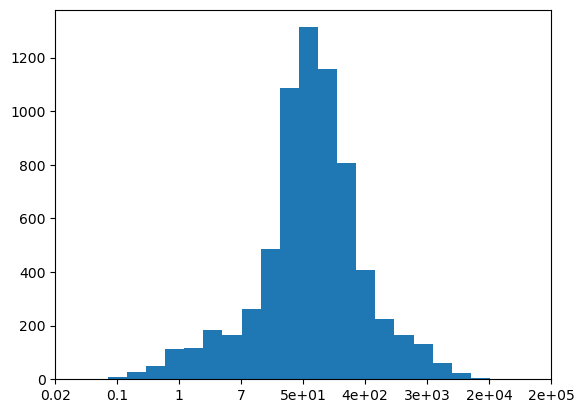

In [9]:
import matplotlib.pyplot as plt
plt.hist(np.log(df2.tpm_max), bins = 20)
xt = plt.xticks()[0]
plt.xticks(ticks = xt, labels = [f"{v:.1g}" for v in np.exp(xt)]);

------------------------------------

## Merging two datasets

In [10]:
dfm = pd.merge(df1, df2, left_on="gene", right_on="Gene ID", how = "outer")
dfm

,SEQ_NAME,chromosome,gene,gene_biotype,transcript_biotype,SEQUENCE,Gene ID,Gene Name,tpm_max
0,ETS1-1_rRNA,R64-1-1:XII:457733:458432:-1,ETS1-1,rRNA,NaN,ATGCGAAAGCAGTTGAAGACAAGTTCGAAAAGAGTTTGGAAACGAA...,ETS1-1,ETS1-1,72.0
1,ETS1-2_rRNA,R64-1-1:XII:466870:467569:-1,ETS1-2,rRNA,NaN,ATGCGAAAGCAGTTGAAGACAAGTTCGAAAAGAGTTTGGAAACGAA...,ETS1-2,ETS1-2,3.0
2,ETS2-1_rRNA,R64-1-1:XII:451575:451785:-1,ETS2-1,rRNA,NaN,TTTTTATTTCTTTCTAAGTGGGTACTGGCAGGAGCCGGGGCCTAGT...,ETS2-1,ETS2-1,8.0
3,ETS2-2_rRNA,R64-1-1:XII:460712:460922:-1,ETS2-2,rRNA,NaN,TTTTTATTTCTTTCTAAGTGGGTACTGGCAGGAGCCGGGGCCTAGT...,NaN,NaN,NaN
4,HRA1_ncRNA,R64-1-1:I:99305:99868:1,HRA1,ncRNA,NaN,GGGCCCTTTCTTCCGTTTGAACGTAAAGGCATTTTTGAGACCATTA...,HRA1,HRA1,3.0
...,...,...,...,...,...,...,...,...,...
7083,tY(GUA)J2_tRNA,R64-1-1:X:542956:543044:-1,tY(GUA)J2,tRNA,tRNA,CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAAATCTTGA...,tY(GUA)J2,SUP4,3.0
7084,tY(GUA)M1_tRNA,R64-1-1:XIII:168795:168883:1,tY(GUA)M1,tRNA,tRNA,CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAAATCTTGA...,tY(GUA)M1,SUP5,6.0
7085,tY(GUA)M2_tRNA,R64-1-1:XIII:837928:838016:1,tY(GUA)M2,tRNA,tRNA,CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAAATCTTGA...,NaN,NaN,NaN
7086,tY(GUA)O_tRNA,R64-1-1:XV:288192:288280:1,tY(GUA)O,tRNA,tRNA,CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAAATCTTGA...,tY(GUA)O,SUP3,3.0


In [11]:
dfm[[type(row) == float for row in dfm.SEQUENCE]]  # transcription levels without a sequence

,SEQ_NAME,chromosome,gene,gene_biotype,transcript_biotype,SEQUENCE,Gene ID,Gene Name,tpm_max
160,NaN,NaN,NaN,NaN,NaN,NaN,YAR009C,YAR009C,3.0
161,NaN,NaN,NaN,NaN,NaN,NaN,YAR010C,YAR010C,1.0
196,NaN,NaN,NaN,NaN,NaN,NaN,YBL005W-B,YBL005W-B,1.0
302,NaN,NaN,NaN,NaN,NaN,NaN,YBL100W-B,YBL100W-B,7.0
331,NaN,NaN,NaN,NaN,NaN,NaN,YBR012W-B,YBR012W-B,2.0
667,NaN,NaN,NaN,NaN,NaN,NaN,YCL019W,YCL019W,4.0
1136,NaN,NaN,NaN,NaN,NaN,NaN,YDR034C-D,YDR034C-D,5.0
1203,NaN,NaN,NaN,NaN,NaN,NaN,YDR098C-B,YDR098C-B,7.0
1278,NaN,NaN,NaN,NaN,NaN,NaN,YDR170W-A,YDR170W-A,0.4
1322,NaN,NaN,NaN,NaN,NaN,NaN,YDR210C-D,YDR210C-D,5.0


In [12]:
dfm[[np.isnan(row) for row in dfm.tpm_max]]  # sequence without transcription levels

,SEQ_NAME,chromosome,gene,gene_biotype,transcript_biotype,SEQUENCE,Gene ID,Gene Name,tpm_max
3,ETS2-2_rRNA,R64-1-1:XII:460712:460922:-1,ETS2-2,rRNA,NaN,TTTTTATTTCTTTCTAAGTGGGTACTGGCAGGAGCCGGGGCCTAGT...,NaN,NaN,NaN
13,PWR1_ncRNA,R64-1-1:IX:395999:396939:1,PWR1,ncRNA,NaN,CGGATGTGTGGATAAAAAGAACATGGAAAACGAGTGCAGCAACGAC...,NaN,NaN,NaN
14,Q0010_mRNA,R64-1-1:Mito:3952:4338:1,Q0010,protein_coding,NaN,ATATATTATATTATATTTTTATATAATATATTATTAATTATTATTT...,NaN,NaN,NaN
15,Q0017_mRNA,R64-1-1:Mito:4254:4415:1,Q0017,protein_coding,NaN,ATGTGTGCTCTATATATATTTAATATTCTGGTTATTATCACCCACC...,NaN,NaN,NaN
17,Q0032_mRNA,R64-1-1:Mito:11667:11957:1,Q0032,protein_coding,NaN,ATATTAATAATATATATATTATTTATTATAATGAAAACCTATCCTA...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
7069,tV(UAC)Q_tRNA,R64-1-1:Mito:78533:78608:1,tV(UAC)Q,tRNA,NaN,AGGAGATTAGCTTAATTGGTATAGCATTCGTTTTACACACGAAAGA...,NaN,NaN,NaN
7072,tW(CCA)J_tRNA,R64-1-1:X:415931:416036:-1,tW(CCA)J,tRNA,NaN,GAAGCGGTGGCTCAATGGTAGAGCTTTCGACTCCAAATCGAAGGGT...,NaN,NaN,NaN
7076,tW(UCA)Q_tRNA,R64-1-1:Mito:9374:9447:1,tW(UCA)Q,tRNA,NaN,AAGGATATAGTTTAATGGTAAAACAGTTGATTTCAAATCAATCATT...,NaN,NaN,NaN
7085,tY(GUA)M2_tRNA,R64-1-1:XIII:837928:838016:1,tY(GUA)M2,tRNA,tRNA,CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAAATCTTGA...,NaN,NaN,NaN
